# RizardAI Emotion Classification Model Training

**Dataset**: GoEmotions (Google, 58k Reddit comments, 27 emotions)

**Target**: Lightweight browser-deployable model for chat emotion detection

## Setup & Installation

In [2]:
import sys
import subprocess
import importlib

# List of packages to install
packages = [
    "transformers",
    "datasets",
    "scikit-learn",
    "seaborn",
    "matplotlib",
    "tqdm",
    "torch",
    "torchvision",
    "torchaudio",
    "plotly",
    "scipy",
    "pandas",
    "numpy"
]
for package in packages:
    try:
        # Try to import first
        importlib.import_module(package.replace("-", "_"))
    except ImportError:
        # If not installed, install it
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import random
import warnings
warnings.filterwarnings('ignore')
try:
    from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "transformers", "-q"])
    from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Datasets
try:
    from datasets import load_dataset
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "datasets", "-q"])
    from datasets import load_dataset

## Setup & Config

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

EMOTION_MAP = {
    0: "neutral",
    1: "happy",
    2: "sad",
    3: "angry",
    4: "fear",
    5: "surprise",
    6: "disgust"
}

GOEMOTIONS_TO_7 = {
    "neutral": 0,
    "admiration": 1, "amusement": 1, "approval": 1, "gratitude": 1,
    "joy": 1, "love": 1, "optimism": 1, "excitement": 1, "caring": 1, "pride": 1,
    "sadness": 2, "disappointment": 2, "grief": 2, "remorse": 2,
    "anger": 3, "annoyance": 3, "disapproval": 3,
    "fear": 4, "nervousness": 4,
    "surprise": 5, "realization": 5,
    "disgust": 6, "embarrassment": 6
}

Device: cpu


## Data Loading

In [4]:
dataset = load_dataset("go_emotions")

texts, labels = [], []
label_names = dataset["train"].features["labels"].feature.names

for item in tqdm(dataset["train"], desc="Processing"):
    if len(item["labels"]) != 1:
        continue

    label_idx = item["labels"][0]
    label_name = label_names[label_idx]

    if label_name not in GOEMOTIONS_TO_7:
        continue

    texts.append(item["text"])
    labels.append(GOEMOTIONS_TO_7[label_name])

print(f"Loaded {len(texts)} samples")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.15, stratify=labels, random_state=42
)

print(f"Train samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Processing: 100%|█████████████████████████████████████████████████████████████| 43410/43410 [00:01<00:00, 25325.27it/s]

Loaded 33584 samples
Train samples: 28546
Validation samples: 5038


## Define Model Classes

In [5]:
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_classes, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        return self.classifier(pooled)

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## Training Pipeline

In [6]:
# Import required libraries
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# CRITICAL: Use DistilBERT instead of BERT (40% faster, 60% smaller)
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Optimized settings for CPU training
MAX_LEN = 64  # Reduced from 128 (shorter sequences = faster)
BATCH_SIZE = 64  # Larger batches = more efficient on CPU
EPOCHS = 3  # Reduced from 4
LEARNING_RATE = 3e-5

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"Model: {MODEL_NAME} (faster than BERT)")

# Create datasets with reduced sequence length
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer, MAX_LEN)

# Optimized data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,
    pin_memory=False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE * 2, 
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Train loader: {len(train_loader)} batches (reduced from 893)")
print(f"Val loader: {len(val_loader)} batches")

# Simplified class weights
class_counts = np.bincount(train_labels)
class_weights = (len(train_labels) / (len(class_counts) * class_counts))
class_weights = np.clip(class_weights, 0.5, 5.0)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Update model class for DistilBERT
from transformers import DistilBertModel

class FastEmotionClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        x = self.dropout(pooled_output)
        return self.classifier(x)

def train_epoch(model, loader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    progress_bar = tqdm(loader, desc="Training", ncols=100)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits.detach(), dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.3f}'})
    
    avg_loss = total_loss / len(loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, train_acc, train_f1

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    
    progress_bar = tqdm(loader, desc="Evaluating", ncols=100)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    return avg_loss, acc, f1, precision, recall, all_preds, all_labels

# Initialize model
print("\nInitializing DistilBERT model...")
model = FastEmotionClassifier(MODEL_NAME, num_classes=7).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

print(f"Total steps: {total_steps}")
print(f"\nExpected time per epoch: ~30-40 minutes (vs 140 with BERT)")
print("\nStarting training...\n")

history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [], 
    'val_loss': [], 'val_acc': [], 'val_f1': []
}
best_f1 = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print('='*70)
    
    epoch_start = time.time()
    
    # Training
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, optimizer, scheduler, criterion
    )
    
    # Validation
    val_loss, val_acc, val_f1, val_precision, val_recall, val_preds, val_labels = evaluate(
        model, val_loader, criterion
    )
    
    epoch_time = time.time() - epoch_start
    
    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print results
    print(f"\nResults:")
    print(f"  Train: Loss={train_loss:.4f} | Acc={train_acc:.4f} | F1={train_f1:.4f}")
    print(f"  Val:   Loss={val_loss:.4f} | Acc={val_acc:.4f} | F1={val_f1:.4f}")
    print(f"  Time: {epoch_time:.1f}s ({epoch_time/60:.1f} min)")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_f1': best_f1,
            'config': {
                'num_classes': 7, 
                'model_name': MODEL_NAME,
                'max_len': MAX_LEN
            }
        }, 'best_emotion_model.pth')
        print(f"  ✓ Saved best model (F1: {val_f1:.4f})")

print(f"\n{'='*70}")
print(f"Training Complete!")
print(f"Best Validation F1: {best_f1:.4f}")
print(f"Total time: {sum(history['train_loss']):.1f} seconds")
print('='*70)

# IMPORTANT: Update EMOTION_MAP loading for DistilBERT
print("\nNOTE: When loading this model later, use:")
print(f"  MODEL_NAME = '{MODEL_NAME}'")
print(f"  MAX_LEN = {MAX_LEN}")

PyTorch version: 2.8.0+cpu
Device: cpu
Model: distilbert-base-uncased (faster than BERT)
Train loader: 447 batches (reduced from 893)
Val loader: 40 batches


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Initializing DistilBERT model...
Model parameters: 66,368,263
Total steps: 1341

Expected time per epoch: ~30-40 minutes (vs 140 with BERT)

Starting training...


Epoch 1/3


Evaluating: 100%|███████████████████████████████████████████████████| 40/40 [01:55<00:00,  2.88s/it]



Results:
  Train: Loss=1.8707 | Acc=0.5225 | F1=0.3969
  Val:   Loss=1.6941 | Acc=0.6378 | F1=0.5400
  Time: 2561.6s (42.7 min)
  ✓ Saved best model (F1: 0.5400)

Epoch 2/3


Evaluating: 100%|███████████████████████████████████████████████████| 40/40 [01:05<00:00,  1.64s/it]



Results:
  Train: Loss=1.5654 | Acc=0.6974 | F1=0.6197
  Val:   Loss=1.6746 | Acc=0.6332 | F1=0.5378
  Time: 2295.6s (38.3 min)

Epoch 3/3


Evaluating: 100%|███████████████████████████████████████████████████| 40/40 [01:06<00:00,  1.67s/it]



Results:
  Train: Loss=1.4574 | Acc=0.7372 | F1=0.6784
  Val:   Loss=1.6810 | Acc=0.6608 | F1=0.5598
  Time: 2178.5s (36.3 min)
  ✓ Saved best model (F1: 0.5598)

Training Complete!
Best Validation F1: 0.5598
Total time: 4.9 seconds

NOTE: When loading this model later, use:
  MODEL_NAME = 'distilbert-base-uncased'
  MAX_LEN = 64


## Visualization

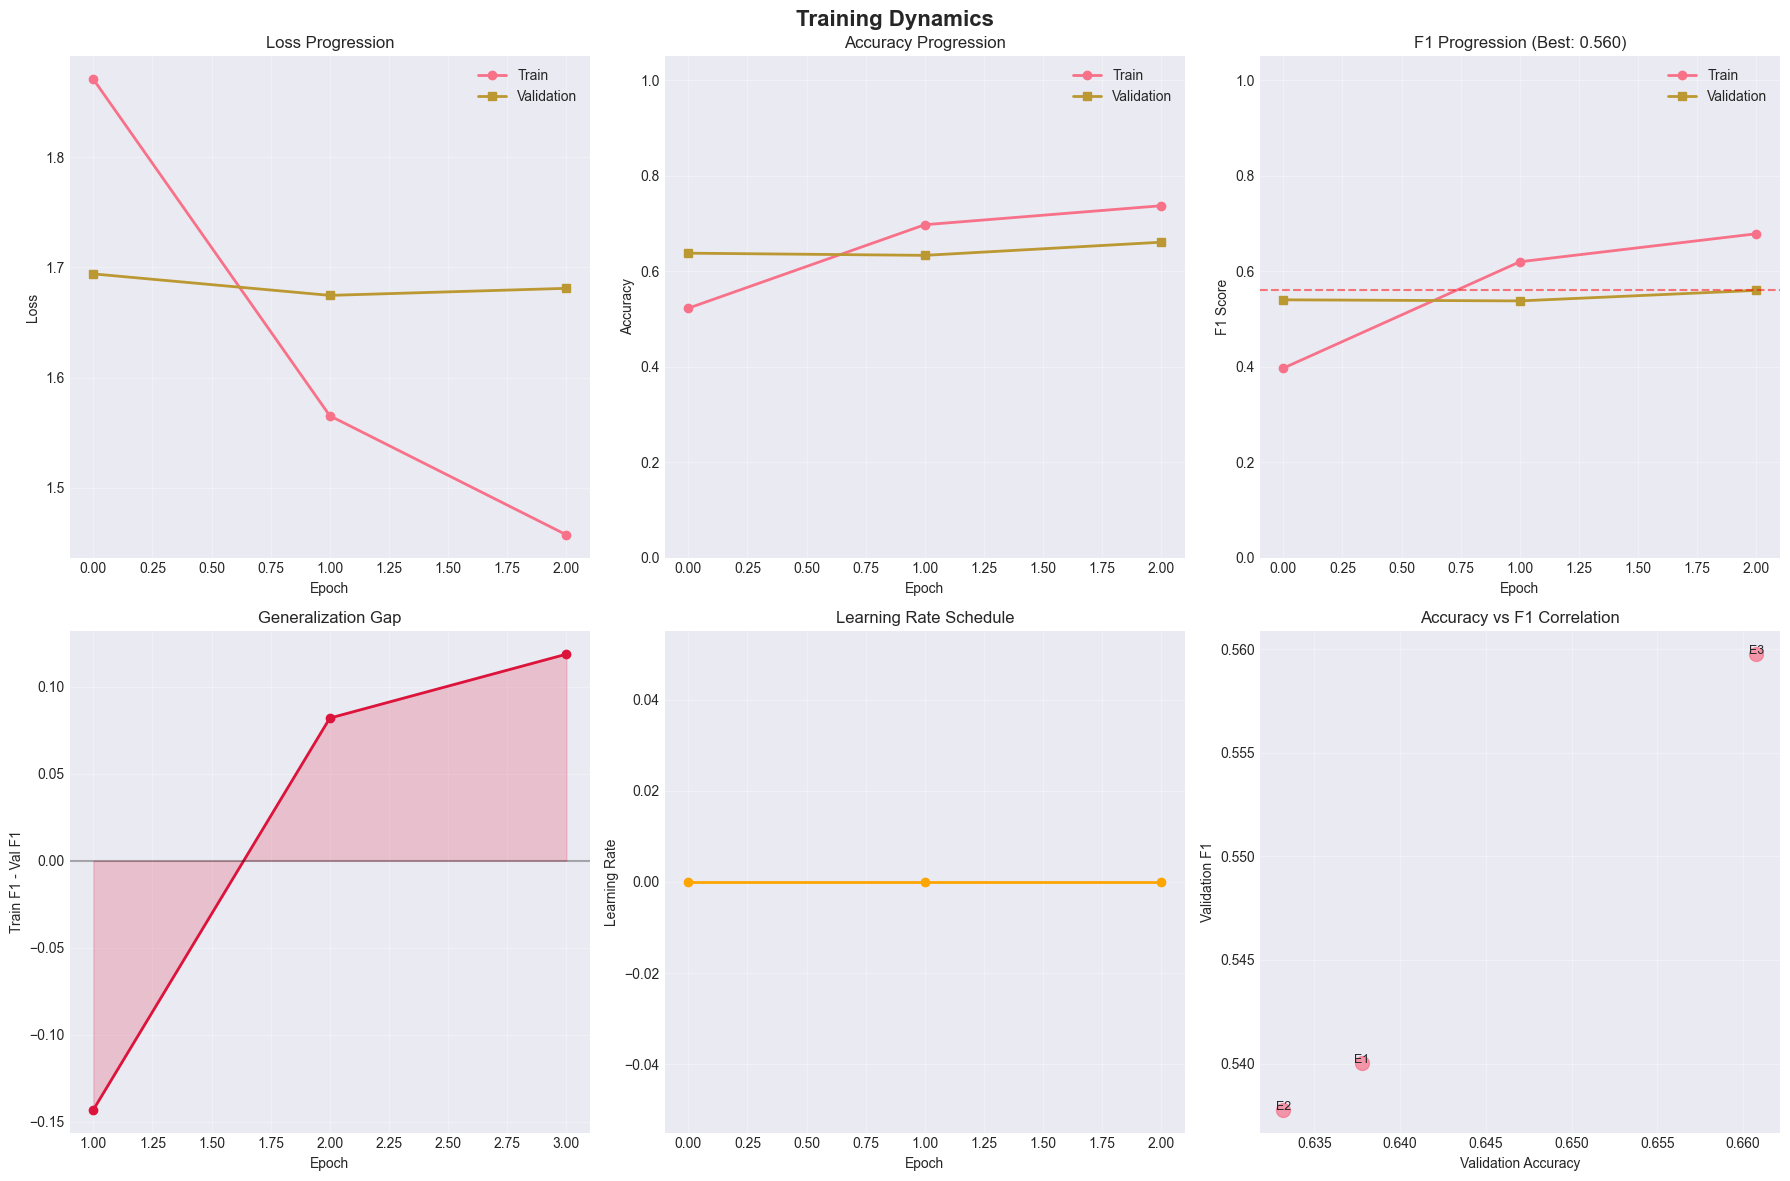

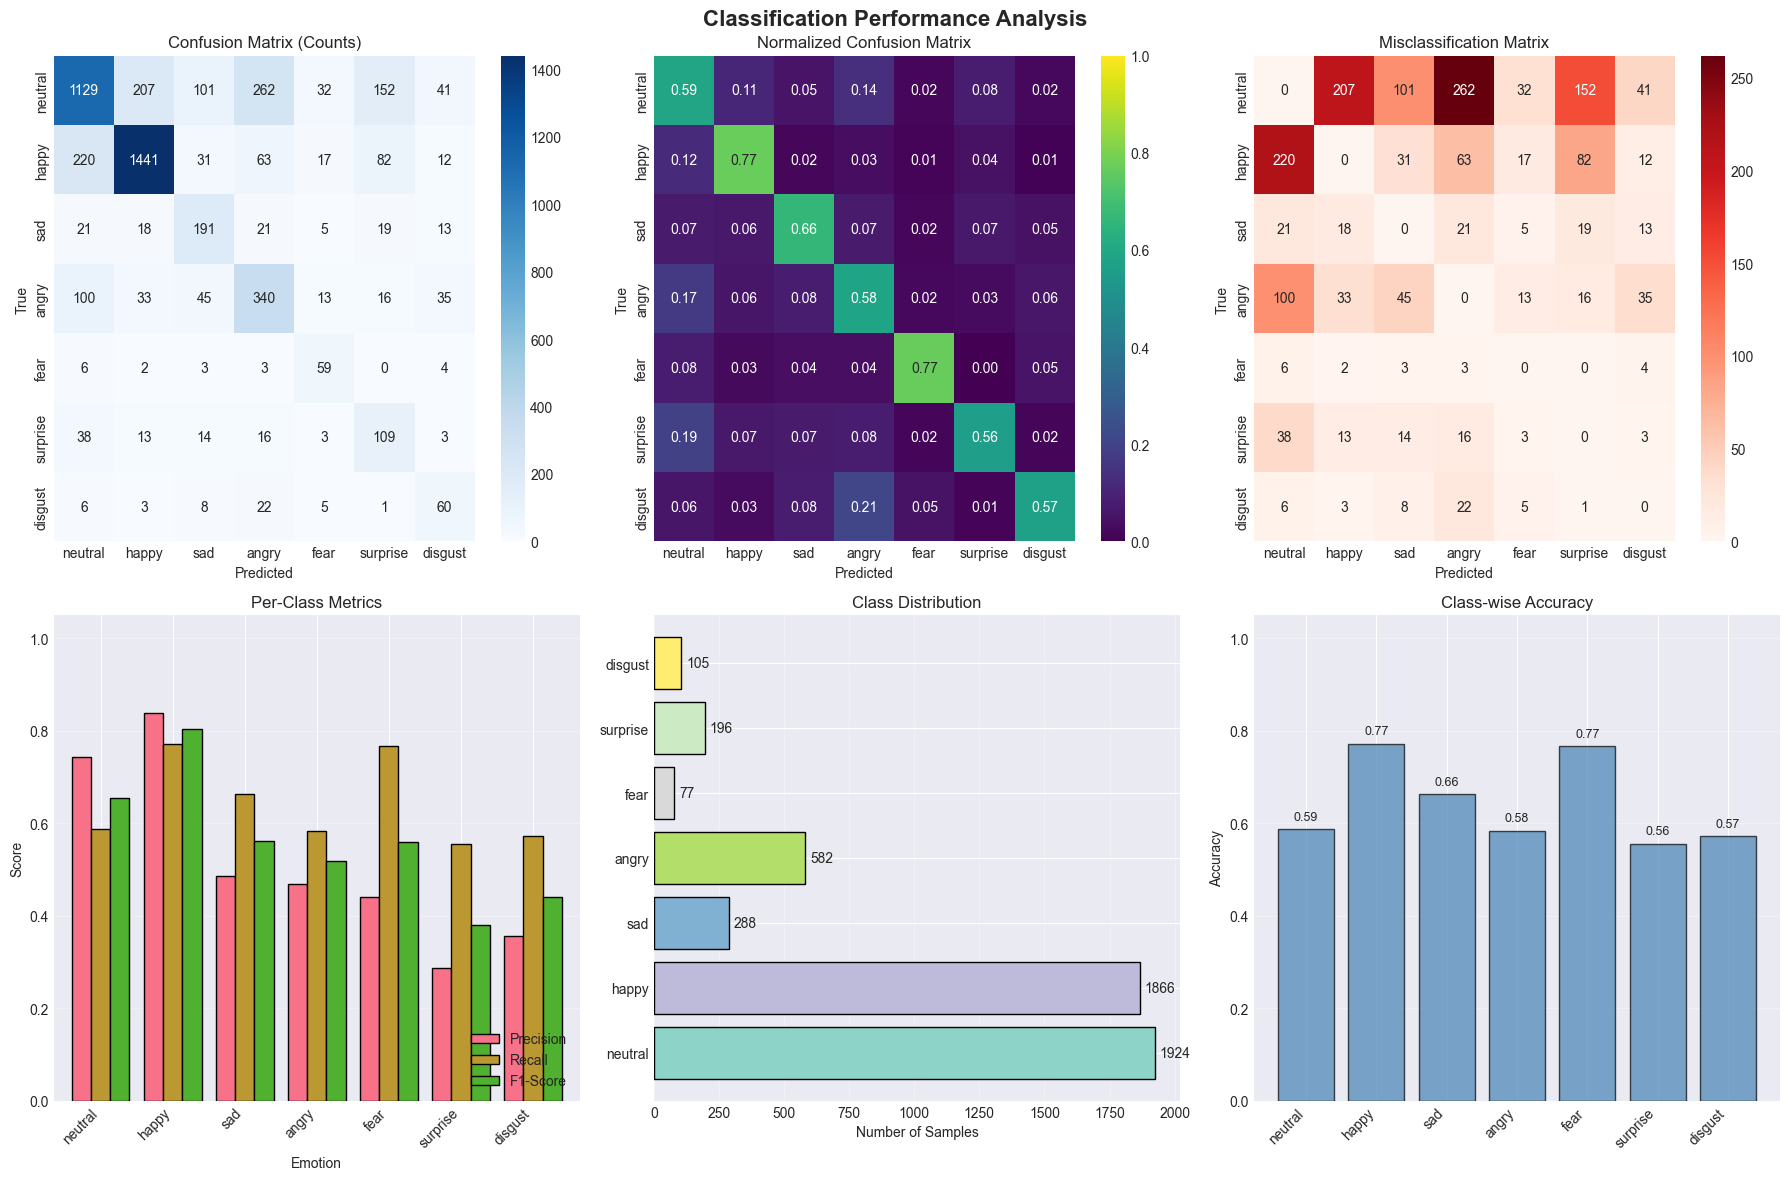

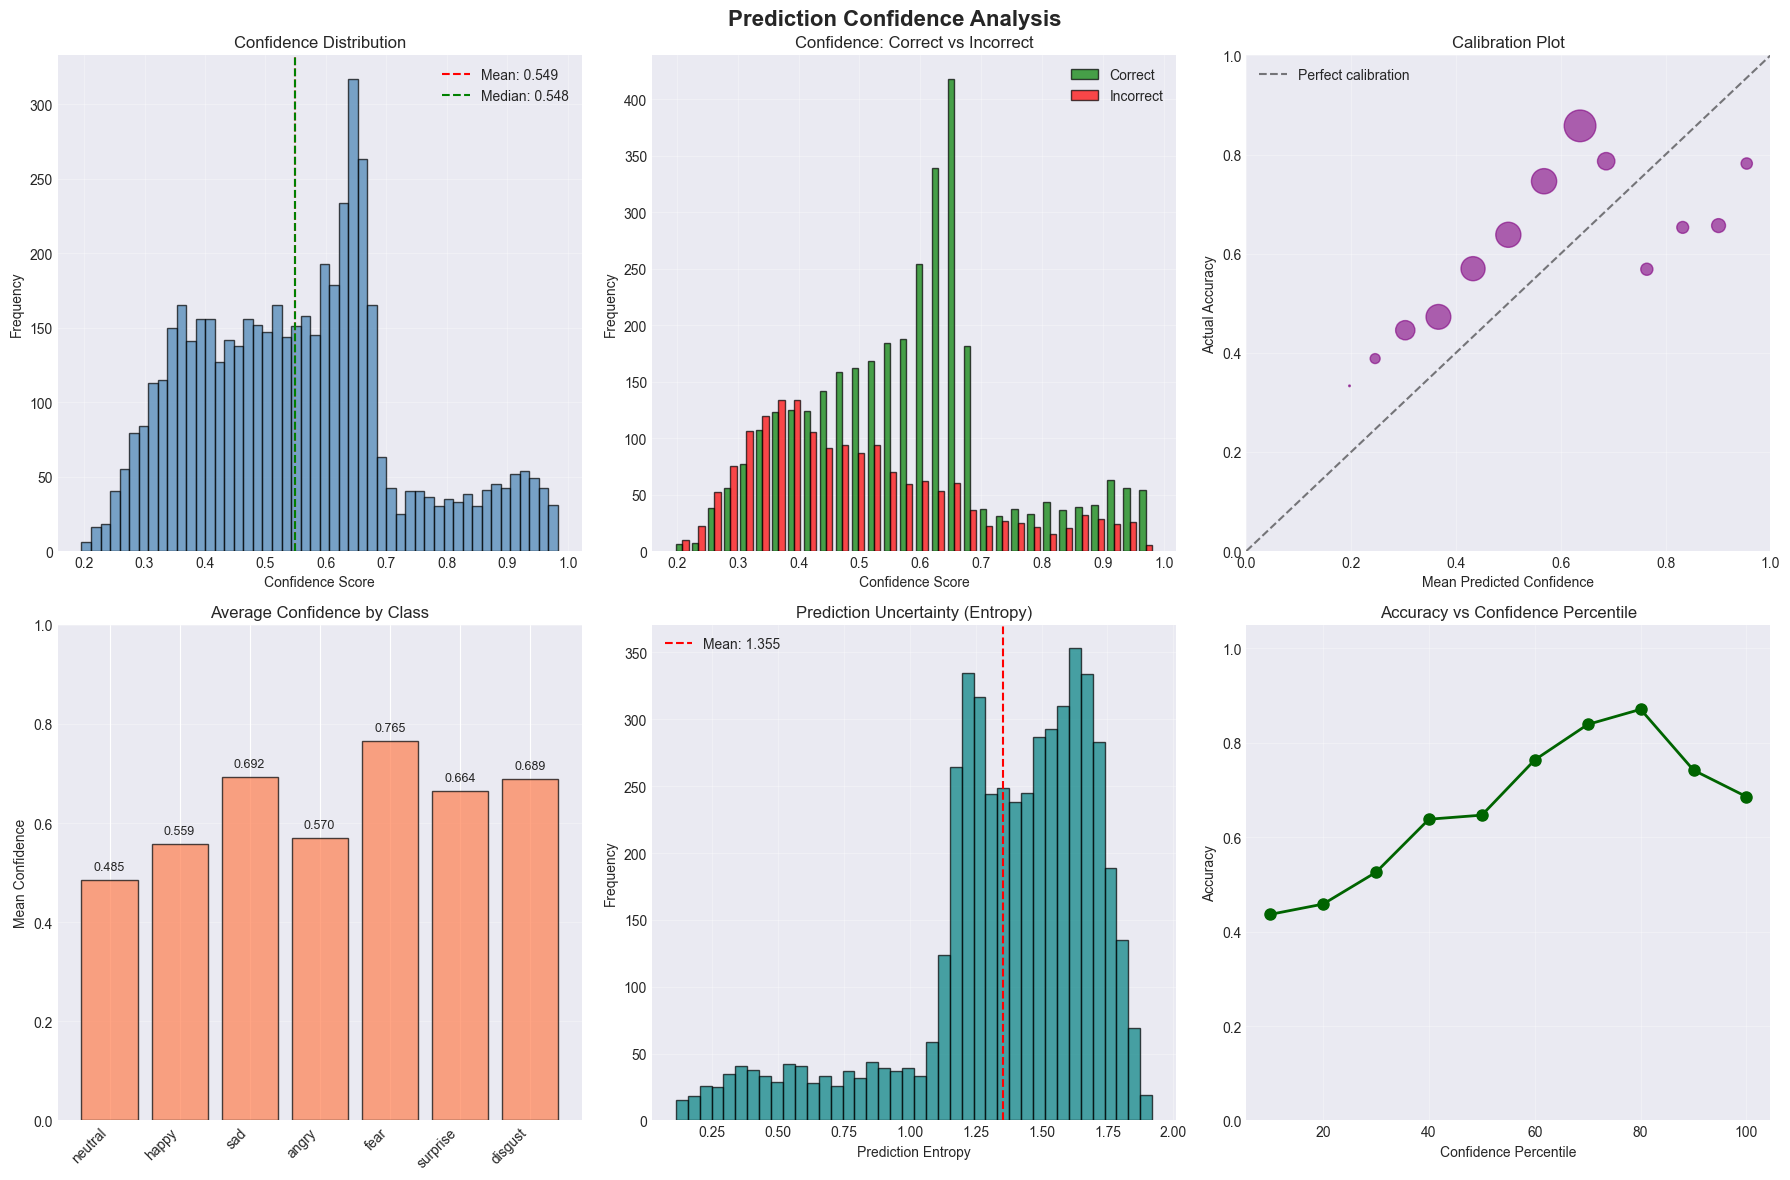

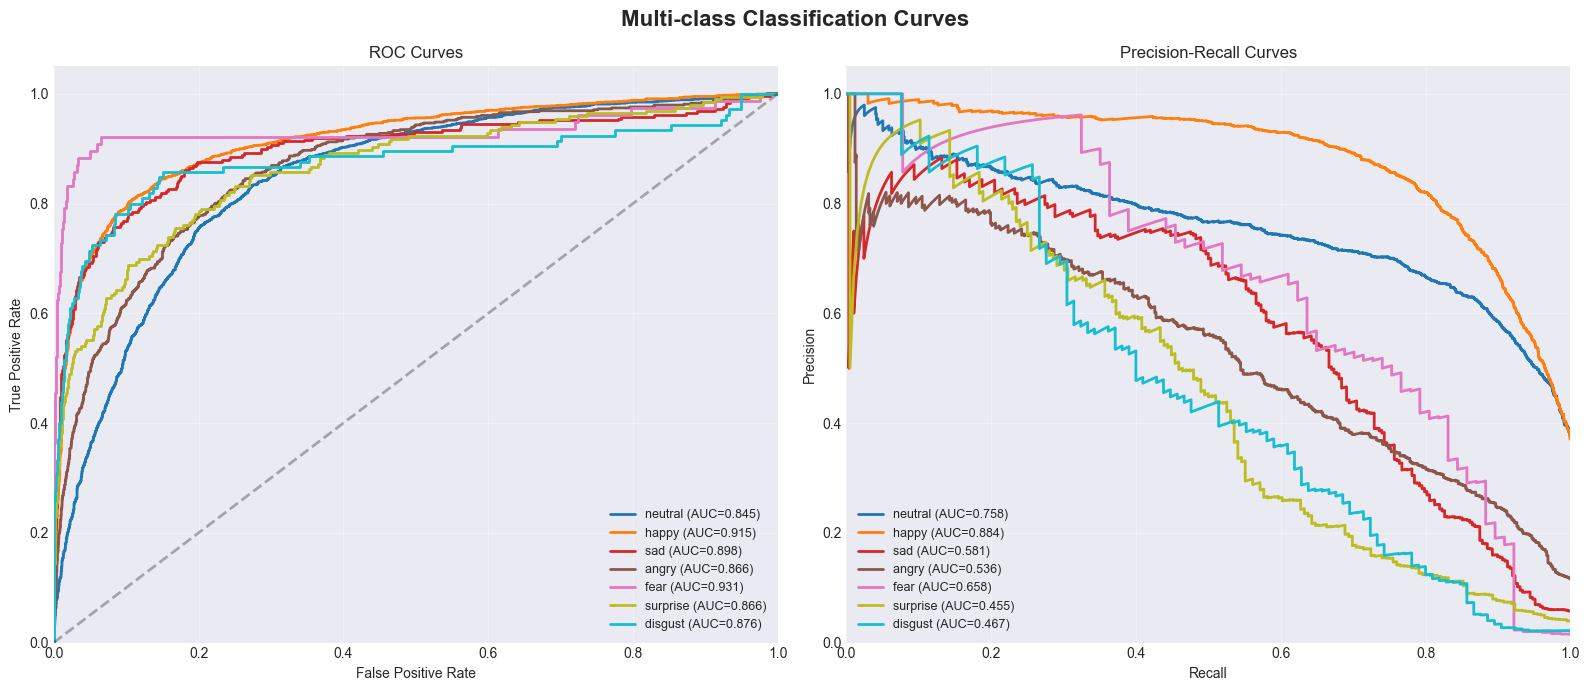


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     neutral     0.7428    0.5868    0.6556      1924
       happy     0.8393    0.7722    0.8044      1866
         sad     0.4860    0.6632    0.5609       288
       angry     0.4677    0.5842    0.5195       582
        fear     0.4403    0.7662    0.5592        77
    surprise     0.2876    0.5561    0.3791       196
     disgust     0.3571    0.5714    0.4396       105

    accuracy                         0.6608      5038
   macro avg     0.5172    0.6429    0.5598      5038
weighted avg     0.7017    0.6608    0.6728      5038


Overall Accuracy: 0.6608
Macro F1-Score: 0.5598
Weighted F1-Score: 0.6728
Mean Confidence: 0.5493 (+/- 0.1702)
Mean Entropy: 1.3549
Correct Predictions Confidence: 0.5758
Incorrect Predictions Confidence: 0.4977


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report, 
                            roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from scipy.stats import entropy

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Collect predictions and probabilities
model.eval()
all_probs, all_preds, all_true_labels = [], [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)
        
        logits = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=1)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_true_labels = np.array(all_true_labels)

# FIGURE 1: Training Dynamics
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 12))
fig1.suptitle('Training Dynamics', fontsize=16, fontweight='bold')

# Loss curves
axes1[0, 0].plot(history['train_loss'], 'o-', label='Train', linewidth=2)
axes1[0, 0].plot(history['val_loss'], 's-', label='Validation', linewidth=2)
axes1[0, 0].set_xlabel('Epoch')
axes1[0, 0].set_ylabel('Loss')
axes1[0, 0].set_title('Loss Progression')
axes1[0, 0].legend()
axes1[0, 0].grid(alpha=0.3)

# Accuracy curves
axes1[0, 1].plot(history['train_acc'], 'o-', label='Train', linewidth=2)
axes1[0, 1].plot(history['val_acc'], 's-', label='Validation', linewidth=2)
axes1[0, 1].set_xlabel('Epoch')
axes1[0, 1].set_ylabel('Accuracy')
axes1[0, 1].set_title('Accuracy Progression')
axes1[0, 1].legend()
axes1[0, 1].grid(alpha=0.3)
axes1[0, 1].set_ylim([0, 1.05])

# F1 curves
axes1[0, 2].plot(history['train_f1'], 'o-', label='Train', linewidth=2)
axes1[0, 2].plot(history['val_f1'], 's-', label='Validation', linewidth=2)
axes1[0, 2].axhline(y=best_f1, color='r', linestyle='--', alpha=0.5)
axes1[0, 2].set_xlabel('Epoch')
axes1[0, 2].set_ylabel('F1 Score')
axes1[0, 2].set_title(f'F1 Progression (Best: {best_f1:.3f})')
axes1[0, 2].legend()
axes1[0, 2].grid(alpha=0.3)
axes1[0, 2].set_ylim([0, 1.05])

# Generalization gap
train_val_gap = np.array(history['train_f1']) - np.array(history['val_f1'])
x = range(1, len(train_val_gap) + 1)
axes1[1, 0].plot(x, train_val_gap, 'o-', linewidth=2, color='crimson')
axes1[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes1[1, 0].fill_between(x, train_val_gap, 0, alpha=0.2, color='crimson')
axes1[1, 0].set_xlabel('Epoch')
axes1[1, 0].set_ylabel('Train F1 - Val F1')
axes1[1, 0].set_title('Generalization Gap')
axes1[1, 0].grid(alpha=0.3)

# Learning rate schedule (if available)
if hasattr(scheduler, 'get_last_lr'):
    lr_history = [scheduler.get_last_lr()[0] for _ in range(len(history['train_loss']))]
    axes1[1, 1].plot(lr_history, 'o-', linewidth=2, color='orange')
    axes1[1, 1].set_xlabel('Epoch')
    axes1[1, 1].set_ylabel('Learning Rate')
    axes1[1, 1].set_title('Learning Rate Schedule')
    axes1[1, 1].grid(alpha=0.3)
else:
    # Loss landscape
    axes1[1, 1].scatter(history['train_loss'], history['val_loss'], 
                       c=range(len(history['train_loss'])), cmap='viridis', s=100)
    axes1[1, 1].plot([0, max(history['train_loss'])], [0, max(history['train_loss'])], 
                    'k--', alpha=0.3)
    axes1[1, 1].set_xlabel('Train Loss')
    axes1[1, 1].set_ylabel('Val Loss')
    axes1[1, 1].set_title('Loss Correlation')
    axes1[1, 1].grid(alpha=0.3)

# Metric correlation
axes1[1, 2].scatter(history['val_acc'], history['val_f1'], s=100, alpha=0.7)
for i in range(len(history['val_acc'])):
    axes1[1, 2].annotate(f'E{i+1}', (history['val_acc'][i], history['val_f1'][i]),
                        fontsize=9, ha='center')
axes1[1, 2].set_xlabel('Validation Accuracy')
axes1[1, 2].set_ylabel('Validation F1')
axes1[1, 2].set_title('Accuracy vs F1 Correlation')
axes1[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURE 2: Confusion Matrices and Per-Class Performance
cm = confusion_matrix(all_true_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
fig2.suptitle('Classification Performance Analysis', fontsize=16, fontweight='bold')

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes2[0, 0],
            xticklabels=[EMOTION_MAP[i] for i in range(7)],
            yticklabels=[EMOTION_MAP[i] for i in range(7)])
axes2[0, 0].set_title('Confusion Matrix (Counts)')
axes2[0, 0].set_xlabel('Predicted')
axes2[0, 0].set_ylabel('True')

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='viridis', ax=axes2[0, 1],
            xticklabels=[EMOTION_MAP[i] for i in range(7)],
            yticklabels=[EMOTION_MAP[i] for i in range(7)],
            vmin=0, vmax=1)
axes2[0, 1].set_title('Normalized Confusion Matrix')
axes2[0, 1].set_xlabel('Predicted')
axes2[0, 1].set_ylabel('True')

# Error matrix
error_matrix = cm.copy()
np.fill_diagonal(error_matrix, 0)
sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds', ax=axes2[0, 2],
            xticklabels=[EMOTION_MAP[i] for i in range(7)],
            yticklabels=[EMOTION_MAP[i] for i in range(7)])
axes2[0, 2].set_title('Misclassification Matrix')
axes2[0, 2].set_xlabel('Predicted')
axes2[0, 2].set_ylabel('True')

# Per-class metrics
report = classification_report(all_true_labels, all_preds,
                              target_names=[EMOTION_MAP[i] for i in range(7)],
                              output_dict=True)

classes = [EMOTION_MAP[i] for i in range(7)]
metrics_df = pd.DataFrame({
    'Precision': [report[cls]['precision'] for cls in classes],
    'Recall': [report[cls]['recall'] for cls in classes],
    'F1-Score': [report[cls]['f1-score'] for cls in classes]
}, index=classes)

metrics_df.plot(kind='bar', ax=axes2[1, 0], width=0.8, edgecolor='black')
axes2[1, 0].set_title('Per-Class Metrics')
axes2[1, 0].set_xlabel('Emotion')
axes2[1, 0].set_ylabel('Score')
axes2[1, 0].set_ylim([0, 1.05])
axes2[1, 0].legend(loc='lower right')
axes2[1, 0].grid(alpha=0.3, axis='y')
plt.setp(axes2[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Class support distribution
supports = [report[cls]['support'] for cls in classes]
axes2[1, 1].barh(classes, supports, color=plt.cm.Set3(np.linspace(0, 1, 7)),
                edgecolor='black')
axes2[1, 1].set_xlabel('Number of Samples')
axes2[1, 1].set_title('Class Distribution')
axes2[1, 1].grid(alpha=0.3, axis='x')
for i, v in enumerate(supports):
    axes2[1, 1].text(v + max(supports)*0.01, i, str(int(v)), va='center')

# Class-wise accuracy
class_acc = [np.mean(all_preds[all_true_labels == i] == i) 
             if np.sum(all_true_labels == i) > 0 else 0 
             for i in range(7)]
axes2[1, 2].bar(classes, class_acc, color='steelblue', edgecolor='black', alpha=0.7)
axes2[1, 2].set_title('Class-wise Accuracy')
axes2[1, 2].set_ylabel('Accuracy')
axes2[1, 2].set_ylim([0, 1.05])
axes2[1, 2].grid(alpha=0.3, axis='y')
plt.setp(axes2[1, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(class_acc):
    axes2[1, 2].text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('classification_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURE 3: Confidence Analysis
confidence_scores = np.max(all_probs, axis=1)
prediction_entropy = entropy(all_probs.T)
correct_mask = (all_preds == all_true_labels)

fig3, axes3 = plt.subplots(2, 3, figsize=(18, 12))
fig3.suptitle('Prediction Confidence Analysis', fontsize=16, fontweight='bold')

# Confidence distribution
axes3[0, 0].hist(confidence_scores, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes3[0, 0].axvline(confidence_scores.mean(), color='red', linestyle='--', 
                   label=f'Mean: {confidence_scores.mean():.3f}')
axes3[0, 0].axvline(np.median(confidence_scores), color='green', linestyle='--',
                   label=f'Median: {np.median(confidence_scores):.3f}')
axes3[0, 0].set_xlabel('Confidence Score')
axes3[0, 0].set_ylabel('Frequency')
axes3[0, 0].set_title('Confidence Distribution')
axes3[0, 0].legend()
axes3[0, 0].grid(alpha=0.3)

# Correct vs incorrect confidence
axes3[0, 1].hist([confidence_scores[correct_mask], confidence_scores[~correct_mask]],
                bins=30, label=['Correct', 'Incorrect'], alpha=0.7, color=['green', 'red'],
                edgecolor='black')
axes3[0, 1].set_xlabel('Confidence Score')
axes3[0, 1].set_ylabel('Frequency')
axes3[0, 1].set_title('Confidence: Correct vs Incorrect')
axes3[0, 1].legend()
axes3[0, 1].grid(alpha=0.3)

# Calibration plot
n_bins = 15
bin_edges = np.linspace(0, 1, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_acc = []
bin_conf = []
bin_count = []

for i in range(n_bins):
    mask = (confidence_scores >= bin_edges[i]) & (confidence_scores < bin_edges[i+1])
    if mask.sum() > 0:
        bin_acc.append(correct_mask[mask].mean())
        bin_conf.append(confidence_scores[mask].mean())
        bin_count.append(mask.sum())

axes3[0, 2].scatter(bin_conf, bin_acc, s=np.array(bin_count)/2, alpha=0.6, color='purple')
axes3[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
axes3[0, 2].set_xlabel('Mean Predicted Confidence')
axes3[0, 2].set_ylabel('Actual Accuracy')
axes3[0, 2].set_title('Calibration Plot')
axes3[0, 2].legend()
axes3[0, 2].grid(alpha=0.3)
axes3[0, 2].set_xlim([0, 1])
axes3[0, 2].set_ylim([0, 1])

# Confidence by class
conf_by_class = [confidence_scores[all_true_labels == i].mean() 
                 for i in range(7)]
axes3[1, 0].bar(classes, conf_by_class, color='coral', edgecolor='black', alpha=0.7)
axes3[1, 0].set_ylabel('Mean Confidence')
axes3[1, 0].set_title('Average Confidence by Class')
axes3[1, 0].grid(alpha=0.3, axis='y')
axes3[1, 0].set_ylim([0, 1])
plt.setp(axes3[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(conf_by_class):
    axes3[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# Entropy distribution
axes3[1, 1].hist(prediction_entropy, bins=40, alpha=0.7, color='teal', edgecolor='black')
axes3[1, 1].axvline(prediction_entropy.mean(), color='red', linestyle='--',
                   label=f'Mean: {prediction_entropy.mean():.3f}')
axes3[1, 1].set_xlabel('Prediction Entropy')
axes3[1, 1].set_ylabel('Frequency')
axes3[1, 1].set_title('Prediction Uncertainty (Entropy)')
axes3[1, 1].legend()
axes3[1, 1].grid(alpha=0.3)

# Confidence-Accuracy relationship
conf_bins = np.percentile(confidence_scores, np.arange(0, 101, 10))
conf_acc_by_decile = []
for i in range(len(conf_bins)-1):
    mask = (confidence_scores >= conf_bins[i]) & (confidence_scores < conf_bins[i+1])
    if mask.sum() > 0:
        conf_acc_by_decile.append(correct_mask[mask].mean())

axes3[1, 2].plot(range(10, 101, 10), conf_acc_by_decile, 'o-', linewidth=2, 
                markersize=8, color='darkgreen')
axes3[1, 2].set_xlabel('Confidence Percentile')
axes3[1, 2].set_ylabel('Accuracy')
axes3[1, 2].set_title('Accuracy vs Confidence Percentile')
axes3[1, 2].grid(alpha=0.3)
axes3[1, 2].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURE 4: ROC and PR Curves
y_true_bin = label_binarize(all_true_labels, classes=range(7))

fig4, axes4 = plt.subplots(1, 2, figsize=(16, 7))
fig4.suptitle('Multi-class Classification Curves', fontsize=16, fontweight='bold')

colors = plt.cm.tab10(np.linspace(0, 1, 7))

# ROC curves
for i, (color, emotion) in enumerate(zip(colors, classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes4[0].plot(fpr, tpr, color=color, lw=2,
                 label=f'{emotion} (AUC={roc_auc:.3f})')

axes4[0].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.3)
axes4[0].set_xlabel('False Positive Rate')
axes4[0].set_ylabel('True Positive Rate')
axes4[0].set_title('ROC Curves')
axes4[0].legend(loc="lower right", fontsize=9)
axes4[0].grid(alpha=0.3)
axes4[0].set_xlim([0, 1])
axes4[0].set_ylim([0, 1.05])

# Precision-Recall curves
for i, (color, emotion) in enumerate(zip(colors, classes)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    pr_auc = auc(recall, precision)
    axes4[1].plot(recall, precision, color=color, lw=2,
                 label=f'{emotion} (AUC={pr_auc:.3f})')

axes4[1].set_xlabel('Recall')
axes4[1].set_ylabel('Precision')
axes4[1].set_title('Precision-Recall Curves')
axes4[1].legend(loc="lower left", fontsize=9)
axes4[1].grid(alpha=0.3)
axes4[1].set_xlim([0, 1])
axes4[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(all_true_labels, all_preds,
                          target_names=classes, digits=4))

accuracy = (all_preds == all_true_labels).mean()
macro_f1 = f1_score(all_true_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_true_labels, all_preds, average='weighted')

print(f"\nOverall Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")
print(f"Mean Confidence: {confidence_scores.mean():.4f} (+/- {confidence_scores.std():.4f})")
print(f"Mean Entropy: {prediction_entropy.mean():.4f}")
print(f"Correct Predictions Confidence: {confidence_scores[correct_mask].mean():.4f}")
print(f"Incorrect Predictions Confidence: {confidence_scores[~correct_mask].mean():.4f}")
print("="*80)

## Deployment Module LLM

Initializing Rizz AI...
Rizz AI initialized on cpu
LLM Status: Active




Start interactive mode? (yes/no):  yes



RIZZ AI - INTERACTIVE MODE

Commands:
  Type their message to analyze
  'vibe: [flirty/playful/smooth/direct/balanced/interested]' - change style
  'noviz' - toggle visualization
  'quit' - exit
------------------------------------------------------------------------------------------

[Current vibe: balanced | Viz: ON]


Their message:  good moringggg



RIZZ AI ANALYSIS

Their message: "good moringggg"
Your vibe: BALANCED

Analyzing emotion...


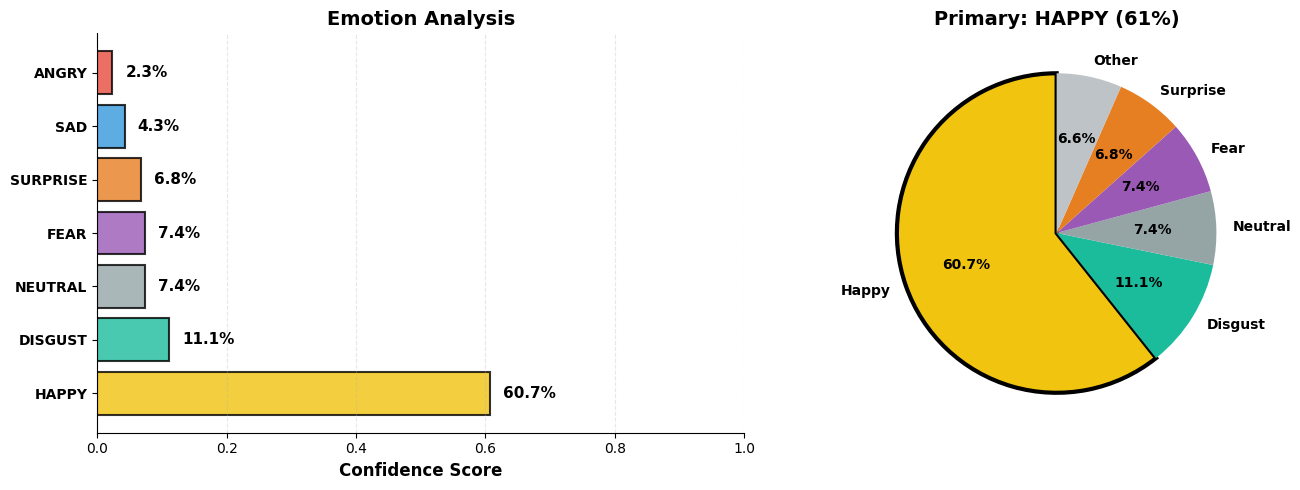


EMOTION: HAPPY (61% confidence)
Interpretation: Likely: They're in a good mood and receptive. Good time to engage.

Generating balanced responses...

------------------------------------------------------------------------------------------
YOUR REPLY OPTIONS:
------------------------------------------------------------------------------------------

SAFE (Solid, low risk):
  "morning sunshine, how's your day shaping up?"

BOLD (Higher risk, more interesting):
  "nice way to wake me up"

PLAYFUL (Fun, engaging):
  "and good morning to the queen of morningggg"

STRATEGY: They're engaged - keep momentum going. Good time to be bolder.


[Current vibe: balanced | Viz: ON]


Their message:  ur so fine



RIZZ AI ANALYSIS

Their message: "ur so fine"
Your vibe: BALANCED

Analyzing emotion...


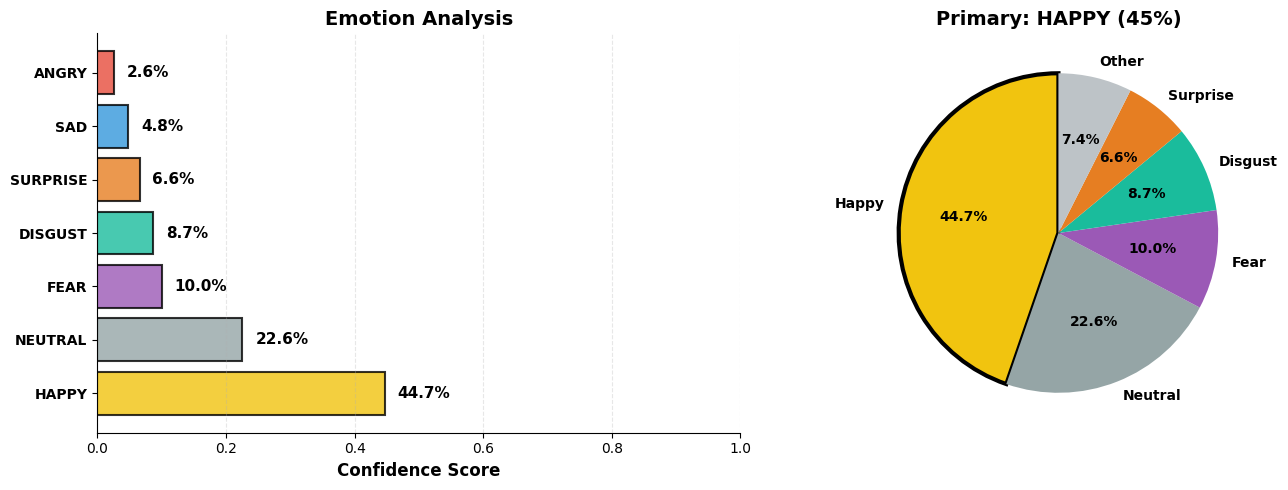


EMOTION: HAPPY (45% confidence)
Interpretation: Mixed signals, but: They're in a good mood and receptive. Good time to engage.

Generating balanced responses...

------------------------------------------------------------------------------------------
YOUR REPLY OPTIONS:
------------------------------------------------------------------------------------------

SAFE (Solid, low risk):
  "i'm glad you think so, made my day"

BOLD (Higher risk, more interesting):
  "that's the nicest thing someone's said to me in a while"

PLAYFUL (Fun, engaging):
  "you're making me blush"

STRATEGY: They're engaged - keep momentum going. Good time to be bolder.


[Current vibe: balanced | Viz: ON]


Their message:  punish me daddy



RIZZ AI ANALYSIS

Their message: "punish me daddy"
Your vibe: BALANCED

Analyzing emotion...


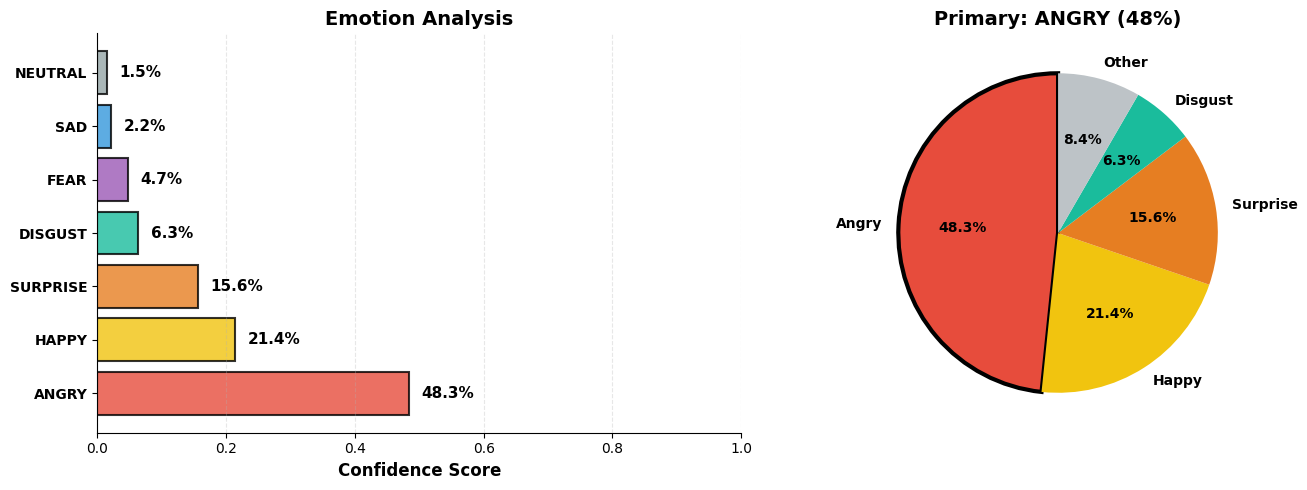


EMOTION: ANGRY (48% confidence)
Interpretation: Mixed signals, but: There's tension. Tread carefully or address it directly.

Generating balanced responses...

------------------------------------------------------------------------------------------
YOUR REPLY OPTIONS:
------------------------------------------------------------------------------------------

SAFE (Solid, low risk):
  "sorry to hear that, how can i make it up to you?"

BOLD (Higher risk, more interesting):
  "that sounds like a promise you're trying to get me to keep"

PLAYFUL (Fun, engaging):
  "sounds like you're in trouble, care to explain?"

STRATEGY: De-escalate or address the issue directly.


[Current vibe: balanced | Viz: ON]


KeyboardInterrupt: Interrupted by user

In [11]:
import requests
import json
import time
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, DistilBertModel
import warnings
warnings.filterwarnings('ignore')

# Model configuration (must match training)
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Emotion mapping (must match training)
EMOTION_MAP = {
    0: 'neutral',
    1: 'happy', 
    2: 'sad',
    3: 'angry',
    4: 'fear',
    5: 'surprise',
    6: 'disgust'
}

# Model class definition
class FastEmotionClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        x = self.dropout(pooled_output)
        return self.classifier(x)
class RizzAI:
    def __init__(self, model_path='best_emotion_model.pth', api_key=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.max_len = MAX_LEN
        
        # Load emotion model
        checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
        self.model = FastEmotionClassifier(MODEL_NAME, num_classes=7)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
        
        self.emotion_map = EMOTION_MAP
        self.api_key = api_key
        self.api_url = "https://api.cerebras.ai/v1/chat/completions"  # Fixed typo
        
        # Emotion colors for visualization
        self.emotion_colors = {
            'neutral': '#95a5a6',
            'happy': '#f1c40f',
            'sad': '#3498db',
            'angry': '#e74c3c',
            'fear': '#9b59b6',
            'surprise': '#e67e22',
            'disgust': '#1abc9c'
        }
        
        print(f"Rizz AI initialized on {self.device}")
        print(f"LLM Status: {'Active' if self.api_key else 'No API key'}")
    
    def analyze_emotion(self, message: str) -> Dict:
        encoding = self.tokenizer(
            message,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            logits = self.model(input_ids, attention_mask)
            probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
        
        msg_lower = message.lower()
        
        flirty_keywords = [
            'tonight', 'later', 'come over', 'hang out', 'meet up',
            'miss you', 'miss u', 'thinking about', 'thinking of',
            'cant stop', "can't stop", 'been thinking',
            'wanna', 'want to', 'wish you', 'wish u',
            'you and me', 'just us', 'alone',
            'cute', 'hot', 'sexy', 'beautiful', 'gorgeous', 'handsome',
            'kiss', 'hug', 'cuddle', 'hold you', 'hold u',
            'netflix', 'chill', 'movie', 'late night',
            'sleepover', 'stay over', 'spend the night',
            'snap', 'pic', 'picture', 'photo',
            'what are you wearing', 'whatcha wearing',
            'send me', 'show me',
            'come here', 'get over here',
            'waiting for', 'cant wait', "can't wait",
            'excited', 'nervous',
            'date', 'dinner', 'drinks', 'coffee',
            'ride', 'pick you up', 'drive over'
        ]
        
        sexual_keywords = [
            'things to you', 'do things', 'gonna do',
            'make you', 'do you', 'want you', 'need you',
            'bed', 'bedroom', 'sheets',
            'body', 'touch', 'feel',
            'lips', 'skin', 'hands',
            'turn me on', 'turned on', 'horny',
            'daddy', 'baby', 'babe',
            'naughty', 'bad', 'dirty',
            'taste', 'bite', 'lick',
            'pull', 'grab', 'squeeze',
            'back', 'neck', 'legs', 'thighs',
            'undress', 'naked', 'strip',
            'hard', 'wet', 'tight',
            'moan', 'scream',
            'pleasure', 'tease', 'seduce',
            'dominate', 'control', 'submission',
            'spank', 'choke', 'rough',
            'slow', 'gentle', 'soft',
            'all night', 'until morning',
            'satisfied', 'fulfill',
            'fantasy', 'imagine', 'dream about',
            'do you send', 'fuck', 'wanna clap'
        ]
        
        romantic_keywords = [
            'love', 'adore', 'care about',
            'special', 'amazing', 'perfect',
            'smile', 'laugh', 'happy',
            'butterflies', 'heart',
            'relationship', 'together', 'us',
            'forever', 'always',
            'boyfriend', 'girlfriend',
            'feelings', 'feel about',
            'like you', 'into you', 'crush'
        ]
        
        all_keywords = flirty_keywords + sexual_keywords + romantic_keywords
        is_flirty = any(keyword in msg_lower for keyword in all_keywords)
        
        adjusted_probs = probs.copy()
        neutral_idx = list(self.emotion_map.values()).index('neutral')
        
        if is_flirty:
            happy_idx = list(self.emotion_map.values()).index('happy')
            surprise_idx = list(self.emotion_map.values()).index('surprise')
            
            adjusted_probs[neutral_idx] *= 0.3
            adjusted_probs[happy_idx] += 0.3
            adjusted_probs[surprise_idx] += 0.2
            
            adjusted_probs = adjusted_probs / adjusted_probs.sum()
        elif adjusted_probs[neutral_idx] > 0.4:
            reduction = adjusted_probs[neutral_idx] * 0.1
            adjusted_probs[neutral_idx] -= reduction
            for i in range(len(adjusted_probs)):
                if i != neutral_idx:
                    adjusted_probs[i] += reduction / (len(adjusted_probs) - 1)
        
        pred_idx = adjusted_probs.argmax()
        primary_emotion = self.emotion_map[pred_idx]
        primary_confidence = float(adjusted_probs[pred_idx])
        
        emotion_scores = [(self.emotion_map[i], float(adjusted_probs[i])) for i in range(7)]
        emotion_scores = sorted(emotion_scores, key=lambda x: x[1], reverse=True)
        
        intensity = primary_confidence
        uncertainty = -np.sum(adjusted_probs * np.log(adjusted_probs + 1e-10))
        
        return {
            'primary_emotion': primary_emotion,
            'confidence': primary_confidence,
            'intensity': intensity,
            'uncertainty': uncertainty,
            'emotion_scores': emotion_scores,
            'all_probs': adjusted_probs,
            'is_flirty': is_flirty
        }
    
    def visualize_emotion(self, analysis: Dict):
        """Create beautiful gradient visualization of emotions"""
        emotions = [e[0] for e in analysis['emotion_scores']]
        scores = [e[1] for e in analysis['emotion_scores']]
        colors = [self.emotion_colors[e] for e in emotions]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Gradient bar chart
        for i, (emotion, score, color) in enumerate(zip(emotions, scores, colors)):
            # Create gradient effect
            gradient = np.linspace(0, 1, 256).reshape(1, -1)
            gradient = np.vstack((gradient, gradient))
            
            ax1.barh(i, score, color=color, alpha=0.8, edgecolor='black', linewidth=1.5)
            ax1.text(score + 0.02, i, f'{score:.1%}', va='center', fontweight='bold', fontsize=11)
        
        ax1.set_yticks(range(len(emotions)))
        ax1.set_yticklabels([e.upper() for e in emotions], fontweight='bold')
        ax1.set_xlabel('Confidence Score', fontweight='bold', fontsize=12)
        ax1.set_title('Emotion Analysis', fontweight='bold', fontsize=14)
        ax1.set_xlim(0, 1.0)
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        
        # Pie chart with gradient
        primary = analysis['primary_emotion']
        primary_conf = analysis['confidence']
        
        # Group small emotions
        display_emotions = []
        display_scores = []
        display_colors = []
        
        for emotion, score in analysis['emotion_scores']:
            if score > 0.05:  # Only show >5%
                display_emotions.append(emotion.capitalize())
                display_scores.append(score)
                display_colors.append(self.emotion_colors[emotion])
        
        if len(display_emotions) < len(emotions):
            other_score = sum(s for e, s in analysis['emotion_scores'] if s <= 0.05)
            if other_score > 0:
                display_emotions.append('Other')
                display_scores.append(other_score)
                display_colors.append('#bdc3c7')
        
        wedges, texts, autotexts = ax2.pie(
            display_scores,
            labels=display_emotions,
            colors=display_colors,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontweight': 'bold', 'fontsize': 10}
        )
        
        # Highlight primary emotion
        for i, emotion in enumerate(display_emotions):
            if emotion.lower() == primary:
                wedges[i].set_edgecolor('black')
                wedges[i].set_linewidth(3)
        
        ax2.set_title(f'Primary: {primary.upper()} ({primary_conf:.0%})', 
                     fontweight='bold', fontsize=14)
        
        plt.tight_layout()
        plt.show()
    
    def _interpret_emotion(self, analysis: Dict) -> str:
        """Provide human-readable interpretation"""
        emotion = analysis['primary_emotion']
        conf = analysis['confidence']
        
        interpretations = {
            'happy': "They're in a good mood and receptive. Good time to engage.",
            'neutral': "They're being casual. You have room to set the tone.",
            'surprise': "You caught their attention. They're intrigued.",
            'sad': "They might be going through something. Be empathetic.",
            'fear': "They're nervous (could be good nervous). Be reassuring.",
            'angry': "There's tension. Tread carefully or address it directly.",
            'disgust': "Something didn't land well. Time to pivot."
        }
        
        base = interpretations.get(emotion, "Read the vibe and adjust.")
        
        if conf > 0.7:
            return f"Strong signal: {base}"
        elif conf > 0.5:
            return f"Likely: {base}"
        else:
            return f"Mixed signals, but: {base}"
    
    def call_llm(self, messages: List[Dict], temperature: float = 0.85) -> Optional[str]:
        """Call Cerebras LLM API"""
        if not self.api_key:
            raise Exception("No API key provided")
        
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }
        
        payload = {
            "model": "llama3.1-8b",  # Cerebras uses llama models
            "messages": messages,
            "max_tokens": 350,
            "temperature": temperature,
            "top_p": 0.95,
            "stream": False
        }
        
        try:
            response = requests.post(self.api_url, headers=headers, json=payload, timeout=30)
            
            if response.status_code == 200:
                result = response.json()
                return result['choices'][0]['message']['content'].strip()
            else:
                print(f"API Error: {response.status_code}")
                print(f"Response: {response.text}")
                raise Exception(f"API returned status {response.status_code}")
                
        except Exception as e:
            print(f"API call failed: {e}")
            raise
    
    def generate_responses(self, their_message: str, analysis: Dict, 
                          vibe: str = "balanced") -> Dict:
        """Generate contextual reply options"""
        
        emotion = analysis['primary_emotion']
        confidence = analysis['confidence']
        
        system_prompt = """You are a Gen Z dating/texting expert who helps people craft attractive, romantic responses.

YOUR GOAL: Help the user create replies that are charming, show interest, and move things forward romantically.

CRITICAL RULES:
1. Generate ACTUAL TEXT MESSAGES as replies, not descriptions
2. Responses should be flirty, romantic, or show clear interest (appropriate to the vibe)
3. NO parentheses, NO explanations, NO meta-commentary
4. Sound like natural 2024 texting (lowercase, brief, confident)
5. 1-2 sentences MAX per response
6. Be smooth, not desperate or try-hard
7. Create intrigue and attraction

EXAMPLES:
Their message: "what are you up to tonight?"

BAD responses:
- "nothing much" (too boring)
- "just sitting at home" (no energy)
- "(This shows interest)" (not an actual message)

GOOD responses:
SAFE: not much yet, what did you have in mind?
BOLD: honestly hoping you'd ask that
PLAYFUL: was just thinking about you actually

Remember: You're helping with ROMANTIC texting, not casual friend conversation."""

        vibe_guide = {
            'flirty': "Show romantic interest. Light teasing. Make them smile. Suggest you're interested.",
            'playful': "Fun and engaging. Banter with subtle flirtation. Keep it light but interesting.",
            'interested': "Show genuine curiosity about them. Ask good questions. Make them feel special.",
            'smooth': "Confident and charming. Create intrigue. Make them curious about you.",
            'direct': "Clear romantic interest. No games. Bold but not pushy.",
            'balanced': "Mix of interest and playfulness. Safe but clearly more than friends."
        }
        
        user_prompt = """Their message: "%s"

Emotion detected: %s (%d%% confidence)
Your vibe: %s - %s

Generate 3 ROMANTIC/FLIRTY text message replies that will attract them. Make them actual messages, not descriptions.

SAFE option: Solid, shows interest without risk
BOLD option: More forward, clear romantic interest
PLAYFUL option: Fun, flirty banter

Example format:
SAFE: not much yet, what did you have in mind?
BOLD: honestly hoping you'd text me tonight
PLAYFUL: depends... are you offering to make it interesting?

Now generate for their message:
SAFE:
BOLD:
PLAYFUL:""" % (their_message, emotion, int(confidence*100), vibe, vibe_guide.get(vibe, vibe_guide['balanced']))

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
        
        llm_response = self.call_llm(messages)
        
        if not llm_response:
            raise Exception("LLM API call failed. Check API key and connection.")
        
        responses = self._parse_llm_responses(llm_response)
        
        return {
            'responses': responses,
            'interpretation': self._interpret_emotion(analysis),
            'strategy': self._get_strategy(emotion, vibe)
        }
    
    def _validate_responses(self, responses: Dict, their_message: str) -> bool:
        """Basic check if responses are relevant"""
        # Check if responses exist and aren't empty
        return all(len(v.strip()) > 5 for v in responses.values())
    
    def _parse_llm_responses(self, text: str) -> Dict:
        """Parse LLM output"""
        responses = {'safe': '', 'bold': '', 'playful': ''}
        
        # Clean the text
        text = text.strip()
        
        # Remove any explanatory text in parentheses
        import re
        text = re.sub(r'\([^)]*\)', '', text)
        
        # Try line-by-line parsing
        for line in text.split('\n'):
            line = line.strip()
            if line.upper().startswith('SAFE:'):
                responses['safe'] = line.split(':', 1)[1].strip().strip('"').strip("'")
            elif line.upper().startswith('BOLD:'):
                responses['bold'] = line.split(':', 1)[1].strip().strip('"').strip("'")
            elif line.upper().startswith('PLAYFUL:'):
                responses['playful'] = line.split(':', 1)[1].strip().strip('"').strip("'")
        
        # Fallback: try to extract any responses
        if not all(responses.values()):
            lines = [l.strip() for l in text.split('\n') if l.strip() and len(l.strip()) > 3]
            if len(lines) >= 3:
                # Try to find lines with content after colons
                for i, line in enumerate(lines):
                    if ':' in line and i < 3:
                        content = line.split(':', 1)[1].strip().strip('"').strip("'")
                        if content and len(content) > 3:
                            if i == 0:
                                responses['safe'] = content
                            elif i == 1:
                                responses['bold'] = content
                            elif i == 2:
                                responses['playful'] = content
        
        # Last resort: use first 3 non-empty lines
        if not all(responses.values()):
            lines = [l.strip().strip('"').strip("'") for l in text.split('\n') 
                    if l.strip() and len(l.strip()) > 3 and not l.strip().startswith('(')]
            if len(lines) >= 3:
                if not responses['safe']:
                    responses['safe'] = lines[0]
                if not responses['bold']:
                    responses['bold'] = lines[1]
                if not responses['playful']:
                    responses['playful'] = lines[2]
        
        return responses
    
    def _get_strategy(self, emotion: str, vibe: str) -> str:
        """Strategic advice"""
        strategies = {
            'happy': "They're engaged - keep momentum going. Good time to be bolder.",
            'neutral': "They're playing it cool. Set the tone yourself.",
            'surprise': "You have their attention. Build on it.",
            'sad': "Be supportive without overdoing it. Light mood lift.",
            'fear': "They're nervous (maybe about you). Be reassuring.",
            'angry': "De-escalate or address the issue directly.",
            'disgust': "Something went wrong. Pivot or gracefully exit."
        }
        return strategies.get(emotion, "Read the room and adjust.")
    
    def _generate_fallback_responses(self, message: str, analysis: Dict, vibe: str) -> Dict:
        """Context-aware fallback responses"""
        emotion = analysis['primary_emotion']
        msg_lower = message.lower()
        
        # Detect message type
        is_question = '?' in message
        has_tonight = 'tonight' in msg_lower or 'today' in msg_lower or 'rn' in msg_lower
        has_compliment = any(word in msg_lower for word in ['interesting', 'cool', 'funny', 'nice'])
        
        # Generate contextual responses
        if has_tonight:
            responses = {
                'safe': "not much, wbu?",
                'bold': "nothing yet, trying to change that",
                'playful': "depends who's asking"
            }
        elif has_compliment:
            responses = {
                'safe': "haha thanks, you too",
                'bold': "you haven't seen anything yet",
                'playful': "just wait till you actually know me"
            }
        elif is_question:
            responses = {
                'safe': "honestly not much, what about you?",
                'bold': "could be doing something more interesting",
                'playful': "trying to figure that out myself lol"
            }
        else:
            responses = {
                'safe': "yeah for real",
                'bold': "we should talk more about this",
                'playful': "lol okay i see you"
            }
        
        return {
            'responses': responses,
            'interpretation': self._interpret_emotion(analysis),
            'strategy': self._get_strategy(emotion, vibe)
        }
    
    def analyze_and_respond(self, their_message: str, vibe: str = "balanced", 
                           show_viz: bool = True):
        """Full analysis with visualization"""
        print("\n" + "="*90)
        print(f"RIZZ AI ANALYSIS")
        print("="*90)
        
        print(f"\nTheir message: \"{their_message}\"")
        print(f"Your vibe: {vibe.upper()}")
        
        # Emotion Analysis
        print("\nAnalyzing emotion...")
        analysis = self.analyze_emotion(their_message)
        
        # Show visualization
        if show_viz:
            self.visualize_emotion(analysis)
        
        # Text summary
        print(f"\nEMOTION: {analysis['primary_emotion'].upper()} ({analysis['confidence']:.0%} confidence)")
        print(f"Interpretation: {self._interpret_emotion(analysis)}")
        
        # Generate responses
        print(f"\nGenerating {vibe} responses...")
        result = self.generate_responses(their_message, analysis, vibe)
        
        print("\n" + "-"*90)
        print("YOUR REPLY OPTIONS:")
        print("-"*90)
        
        print(f"\nSAFE (Solid, low risk):")
        print(f"  \"{result['responses']['safe']}\"")
        
        print(f"\nBOLD (Higher risk, more interesting):")
        print(f"  \"{result['responses']['bold']}\"")
        
        print(f"\nPLAYFUL (Fun, engaging):")
        print(f"  \"{result['responses']['playful']}\"")
        
        print(f"\nSTRATEGY: {result['strategy']}")
        print("="*90 + "\n")
        
        return result

# Initialize with API key
print("Initializing Rizz AI...")

# Model configuration (must match training)
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 64

# Cerebras API key
api_key = "csk-63ccj48w62eh62y3r2djx4m4wjhx3kxnkty4vhj2htwtd9e2"

rizz = RizzAI(api_key=api_key)

if not rizz.api_key:
    raise Exception("API key not set! Cannot proceed without LLM.")

# Interactive mode
def interactive_rizz():
    print("\n" + "="*90)
    print(f"RIZZ AI - INTERACTIVE MODE")
    print("="*90)
    print("\nCommands:")
    print("  Type their message to analyze")
    print("  'vibe: [flirty/playful/smooth/direct/balanced/interested]' - change style")
    print("  'noviz' - toggle visualization")
    print("  'quit' - exit")
    print("-"*90)
    
    current_vibe = "balanced"
    show_viz = True
    
    while True:
        print(f"\n[Current vibe: {current_vibe} | Viz: {'ON' if show_viz else 'OFF'}]")
        user_input = input("Their message: ").strip()
        
        if not user_input:
            continue
        
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("\nGood luck!")
            break
        
        if user_input.lower().startswith('vibe:'):
            new_vibe = user_input.split(':', 1)[1].strip().lower()
            if new_vibe in ['flirty', 'playful', 'smooth', 'direct', 'balanced', 'interested']:
                current_vibe = new_vibe
                print(f"Vibe set to: {current_vibe}")
            continue
        
        if user_input.lower() == 'noviz':
            show_viz = not show_viz
            print(f"Visualization: {'ON' if show_viz else 'OFF'}")
            continue
        
        try:
            rizz.analyze_and_respond(user_input, current_vibe, show_viz)
        except Exception as e:
            print(f"\nError: {e}")

# Start interactive
print("\n" + "="*90)
start = input("\nStart interactive mode? (yes/no): ").strip().lower()
if start in ['yes', 'y', '']:
    interactive_rizz()